## Churn Modelling

***Churn rate, in its broadest sense, is a measure of the number of individuals or items moving out of a collective group over a specific period. It is one of two primary factors that determine the steady-state level of customers a business will support. (Source -> Wikipedia)***

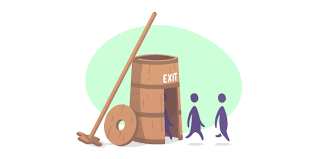

In this notebook the data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.

#### In this notebook you will see

* ***Data Preprocessing***

  1. Importing the libraries
  2. Loading the data.
  3. Encoding categorical data
  4. Splitting the data into training and test set
    
    
* ***Building the ANN(Artificial Neural Network)***

  1. Inititalizing the ANN
  2. Adding the input layer and hidden layers
  3. Compiling the model
  4. Fitting the ANN to the training data
  5. Making the predictions and evaluating the model
  
    
* ***Evaluating, Improving and Tuning the ANN***

  1. Evaluating the model(Using Keras Classifier and K-fold cross validation)
  2. Improving the ANN(Tuning model hyperparameters using Grid Search CV)

## Data Preprocessing

### Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

### Loading the data

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
churn_data = pd.read_csv('/kaggle/input/churn-modelling/Churn_Modelling.csv')

In [ ]:
# Checking the head of the dataframe

churn_data.head()

In [ ]:
# Checking info about data
churn_data.info()

As, we can see RowNumber, CustomerId and Surname are not useful for us here. We will drop these features.

In [ ]:
churn_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1,  inplace = True)

In [ ]:
churn_data.head()

In [ ]:
# Checking how many cities are there in Geography column
churn_data['Geography'].unique()

As, we can see clearly we have categorical data in Geography and Gender column.

We will convert these to one hot representation, so that we can feed data to our model.

### Encoding categorical data

In [ ]:
X = churn_data.iloc[:,:-1]
y = churn_data.iloc[:, -1]

In [ ]:
# For Geography column
X[['Germany','Spain']] = pd.get_dummies(X['Geography'], drop_first = True)
X.drop('Geography', axis = 1, inplace = True)

In [ ]:
# For Gender column
X['Male'] = pd.get_dummies(X['Gender'], drop_first = True)
X.drop('Gender', axis = 1, inplace = True)

In [ ]:
X.head()

### Splitting the data into training and test set

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 51)

In [ ]:
print(X_train.shape)
print(X_test.shape)

Now, let's convert train and test data to numpy arrays because our keras model will require data in array form.

In [ ]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

### Feature scaling

Let's do feature scaling to convert variables to similar scale. So, that all features can be treated equally important.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Check scaled data
# print(X_train)

## Building the ANN model

In this step we will import keras libraries and build an Artificial Neural Network.

In [ ]:
import keras
from keras.models import Sequential 
from keras.layers import Dense

### Initializing the ANN

In [ ]:
model = Sequential()

### Adding the input layer and hidden layers

In [ ]:
# Adding the input layer and first hidden layer
model.add(keras.Input(11,))
model.add(Dense(6, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the second hidden layer
model.add(Dense(6, kernel_initializer = 'uniform', activation = 'relu'))


# Adding the third hidden layer
model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))

### Compiling the ANN

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### Fitting the ANN to the training data

In [ ]:
model.fit(X_train, y_train, batch_size = 10, epochs = 50)

### Making the predictions and evaluating the model

In [ ]:
# Predicting the test set results
y_pred = model.predict(X_test)

y_pred = (y_pred > 0.5)

In [ ]:
# Evaluating the model
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test, y_pred)
print(cm)

acc_score = accuracy_score(y_test, y_pred)
print("Accuracy : ",acc_score)

In [ ]:
# Predicting on new data
new_prediction = model.predict(scaler.fit_transform(np.array([[0.0, 0, 600, 1, 40, 3, 60000, 2, 1, 1, 50000]])))
new_prediction = (new_prediction > 0.5)

print(new_prediction)

But the model we developed here is not generalized because we can't say our model is good by just training it on a single test set.

Can we improve performance of our model. Let's see

## Evaluating, Improving and Tuning the ANN

### Evaluating the ANN

We will be using cross_val_score along with KerasClassifier wrapper to evalute our model.

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

Because our KerasClassifier wrapper expects its first argument to be a function, we will be building a classifier function first.

In [ ]:
# Builing the classifier function
def build_classifier():
    model = Sequential()
    model.add(keras.Input(11,))
    model.add(Dense(6, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(6, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
# Passing values to KerasClassifier 
model = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 50)

In [ ]:
# We are using 10 fold cross validation here
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)

In [ ]:
# Checking the accuracies
print(accuracies)

In [ ]:
# Checking the mean and standard deviation of the accuracies obtained
mean = accuracies.mean()
variance = accuracies.std()
print("Mean : ",mean)
print("Variance : ",variance)

As we can see we are getting a good accuracy and a very small variance therefore we can say that using k-fold cross validation we obtained a more generalized model as compared to the previous one.

But the question is --->  Can we beat this accuracy ??

***Let's see***🤨

### Improving the ANN

Here, we are using Grid Search CV to improve our model by tuning the hyperparameters.

And we are also adding dropout layers to our model to reduce any kind of overfitting.

#### Tuning the model

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Building the classifier function
def build_classifier(optimizer):
    model = Sequential()
    model.add(keras.Input(11,))
    model.add(Dense(6, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(6, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
# Passing values to KerasClassifier
model = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 50)

In [ ]:
# Using Grid Search CV to getting the best parameters
parameters = {'batch_size': [25, 32],
             'epochs': [100, 150],
             'optimizer': ['adam', 'rmsprop']}

grid_search = GridSearchCV(estimator = model, param_grid = parameters,
                          scoring = 'accuracy',
                          cv = 5)

grid_search.fit(X_train, y_train)

In [ ]:
best_parameters = grid_search.best_params_ 
best_accuracy = grid_search.best_score_

In [ ]:
print("Best Parameters : ",best_parameters)
print("Best Accuracy : ",best_accuracy)

***See, the accuracy of our model got increased. Although it's not a big jump but a 1% increase is quite good.***

***So, on this note I'm gonna say bye🤗***

***If you liked the notebook. Please give an upvote 😃***